# Direct Capacity Coupling

---

### 0.1 Prerequisite

- When changing the python class in the lib directory please restart kernel.
- When launching the jupyter notebook please always firstly run this cell.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import constants
import scipy.sparse.linalg
import scipy.sparse as sparse
import qutip.settings as settings
from tqdm import tqdm
import qutip as qt

qt.settings.atol = 1e-100
qt.settings.auto_tidyup_atol = qt.settings.atol
current_dir = os.getcwd()

# Get the parent folder path
parent_dir = os.path.dirname(current_dir)

# Add the parent folder path to sys.path
sys.path.append(parent_dir)

from lib.qubit import qubit
from lib.circuit_cap_coupling import circuit_cap

# plt.style.use("dark_background")
thememap = 'viridis'

# Setting up constants
h = constants.h
hbar = constants.hbar
pi = np.pi

---

The system is composed of two Transmon coupled by a capacitor. The nodes are defined as the graph below :

![circuit](..\img\dcccircuit.png)

#### Table of content :
   1) Visualization of the Hamiltonian
   2) Getting the coupling in term of energy basis
   3) getting the coupling while owrking in the charge basis for the target qubit

### 1 Visualization of the Hamiltonian

In [2]:
# Initialize transmon

# Circuit constant
ng = 0.5
Cc = 18e-15
Ej_p = 18.2e9
Ej_t = 11.8e9
Cp = 270e-15
Ct = 250e-15
ncut_p = 10
ncut_t = 10

# Creation of circuit object
system_1 = circuit_cap(Cc, [qubit(Ej_p, [Cp], ng, ncut_p), qubit(Ej_t, [Ct], ng, ncut_t)])

system_1.print_params()

Ejp:    18.200000000000003 GHz
Ecp:    0.2869663603653203 GHz
Cjp:    270.0 fF
Ejp/Ecp probe: 63.42206792751119
w_probe:    6.162432921919601 GHz
ng probe:    0.5
Ejt:    11.799999999999999 GHz
Ec:    0.309923669194546 GHz
Cjt:    250.0 fF
Ejt/Ect target: 38.073891002474156
w_target:    5.077795771645749 GHz
ng target:    0.5
detunning:    1.084637150273852 GHz
Cc:    18.0 fF


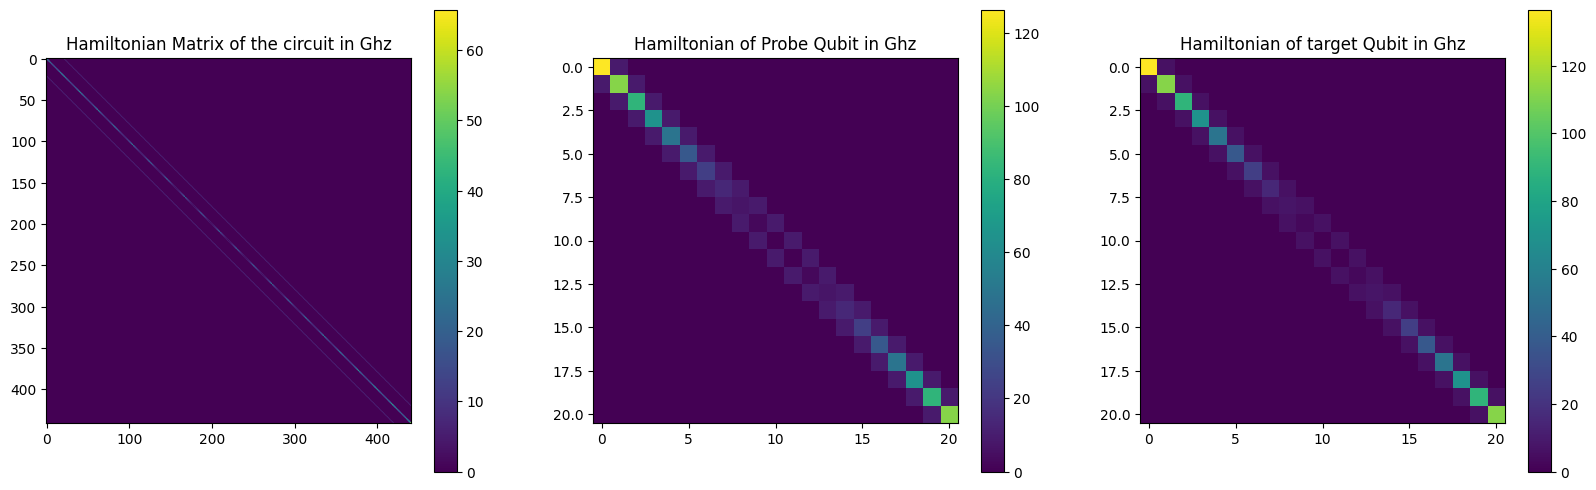

In [3]:
# Exctracting the Hamiltonian
H_circ = system_1.get_H_circuit()
H_p = system_1.get_H_probe()
H_t = system_1.get_H_target()

f = plt.figure(figsize=(20,6))

# Plotting the Hamiltonian
ax1 = f.add_subplot(131)
ax1.title.set_text('Hamiltonian Matrix of the circuit in Ghz')
im1 = ax1.imshow(np.absolute(H_circ.full()) * 1e-9 / constants.h , cmap=plt.get_cmap(thememap))
f.colorbar(im1)

ax2 = f.add_subplot(132)
ax2.title.set_text('Hamiltonian of Probe Qubit in Ghz')
im2 = ax2.imshow(np.absolute(H_p.full()) * 1e-9 / constants.h, cmap=plt.get_cmap(thememap))
f.colorbar(im2)


ax3 = f.add_subplot(133)
ax3.title.set_text('Hamiltonian of target Qubit in Ghz')
im3 = ax3.imshow(np.absolute(H_t.full()) * 1e-9 / constants.h, cmap=plt.get_cmap(thememap))
f.colorbar(im3)

ax1.grid(False)
ax2.grid(False)
ax3.grid(False)

plt.show()

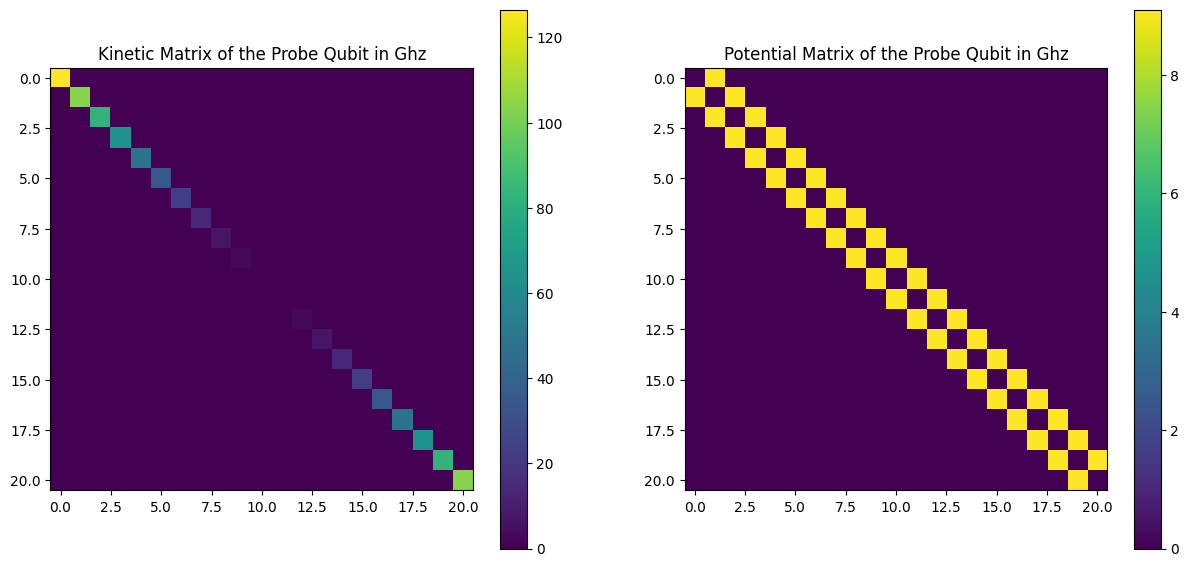

In [4]:
kin_probe = system_1.get_kinetic_probe()
pot_probe = system_1.get_potential_probe()

f = plt.figure(figsize=(15,7))

ax1 = f.add_subplot(121)
ax1.title.set_text('Kinetic Matrix of the Probe Qubit in Ghz')
im1 = ax1.imshow(np.absolute(kin_probe.full()) * 1e-9 / constants.h, cmap=plt.get_cmap(thememap))
f.colorbar(im1)

ax2 = f.add_subplot(122)
ax2.title.set_text('Potential Matrix of the Probe Qubit in Ghz')
im2 = ax2.imshow(np.absolute(pot_probe.full()) * 1e-9 / constants.h, cmap=plt.get_cmap(thememap))
f.colorbar(im2)

ax1.grid(False)
ax2.grid(False)

plt.show()

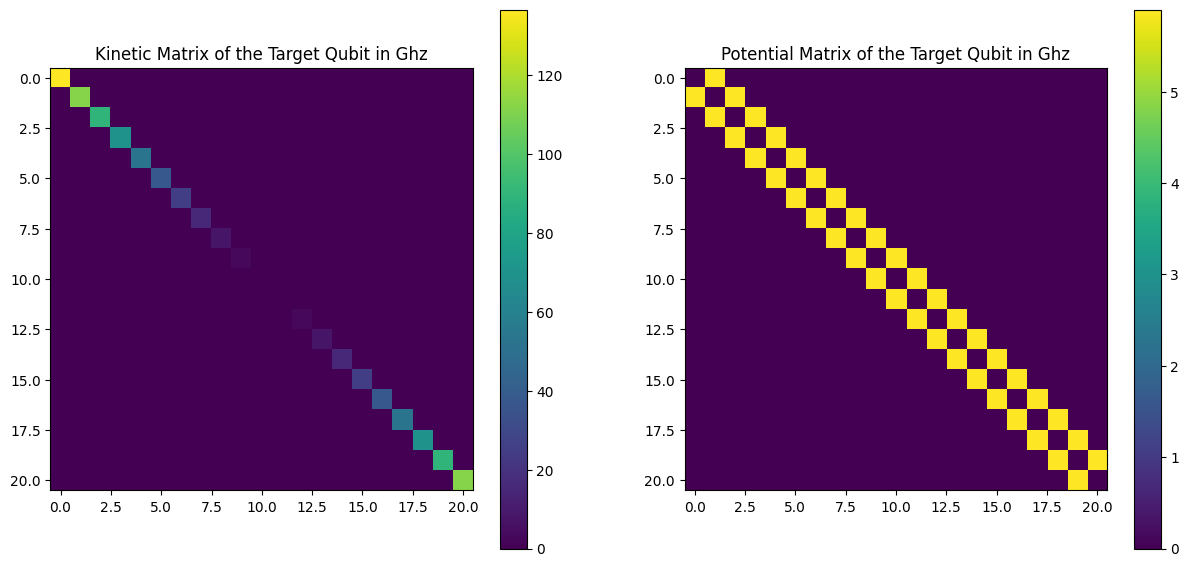

In [5]:
kin_target = system_1.get_kinetic_target()
pot_target = system_1.get_potential_target()

if type(kin_target) == scipy.sparse.csr_matrix:
    kin_target = kin_target.toarray()
    pot_target = pot_target.toarray()

f = plt.figure(figsize=(15,7))

ax1 = f.add_subplot(121)
ax1.title.set_text('Kinetic Matrix of the Target Qubit in Ghz')
im1 = ax1.imshow(np.absolute(kin_target.full()) * 1e-9 / constants.h, cmap=plt.get_cmap(thememap))
f.colorbar(im1)

ax2 = f.add_subplot(122)
ax2.title.set_text('Potential Matrix of the Target Qubit in Ghz')
im2 = ax2.imshow(np.absolute(pot_target.full()) * 1e-9 / constants.h, cmap=plt.get_cmap(thememap))
f.colorbar(im2)
ax1.grid(False)
ax2.grid(False)
plt.show()

---

### 2 Coupling in energy basis


In this first simulation we consider the case of the two transmons as two qubits and want to see the coupling between them in the energy eigenbasis of each two. This means that all the Pauli matrices in this first case of study are one of the two level energy basis of each transmon.
The Hamiltonian form considered for this first simulation is:

\begin{equation}
    H=\Delta _{t}\sigma _{z}^{t}+\Delta _{p}\sigma _{z}^{p}+g_{\parallel}\sigma _{z}^{p}\sigma _{z}^{t}+g_{\perp}\sigma _{x}^{p}\sigma _{z}^{t}
\end{equation}

With the ket notations $| i,j\rangle =\left| i\rangle _{e}^{p}\otimes \right| j\rangle _{e}^{t}$ being the following with all state being energy eigenstates of the transmons. The matrix elements to calculate out of H to get the different parameter of the Hamiltonian are:

\begin{equation}
    \begin{aligned}\langle ++\left| H\right| - -\rangle =g_{\parallel}\\
\langle 0+\left| H\right| 1-\rangle =g_{\perp}\end{aligned}
\end{equation}

Ejp:    18.200000000000003 GHz
Ecp:    0.2869663603653203 GHz
Cjp:    270.0 fF
Ejp/Ecp probe: 63.42206792751119
w_probe:    6.162432921919601 GHz
ng probe:    0.5
Ejt:    11.799999999999999 GHz
Ec:    0.309923669194546 GHz
Cjt:    250.0 fF
Ejt/Ect target: 38.073891002474156
w_target:    5.077904256322749 GHz
ng target:    0
detunning:    1.084528665596852 GHz
Cc:    18.0 fF


100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


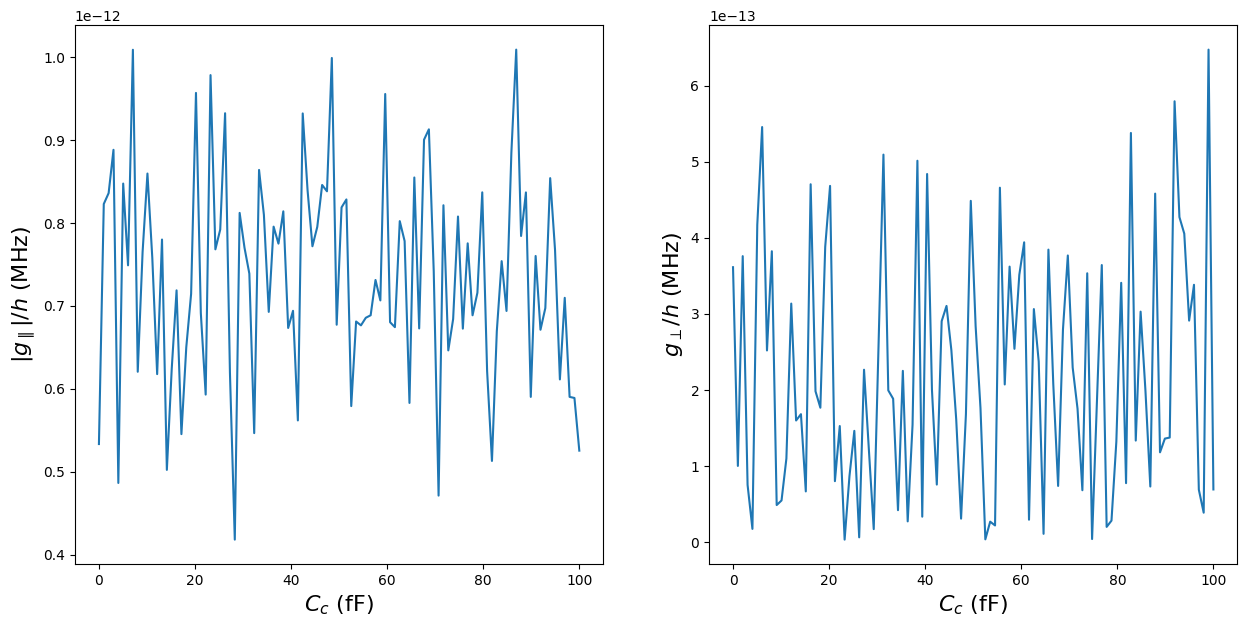

In [8]:
# Initialize transmon

# Circuit constant
ng = 0.5
Cc = 18e-15
Ej_p = 18.2e9
Ej_t = 11.8e9
Cp = 270e-15
Ct = 250e-15
ncut_p = 10
ncut_t = 10

# Creation of circuit object
system_10 = circuit_cap(Cc, [qubit(Ej_p, [Cp], ng, ncut_p), qubit(Ej_t, [Ct], 0, ncut_t)])

system_10.print_params()

Ccs = np.linspace(0, 10e-14, 100)

fig_data_gparr = []
fig_data_gperp = []

for Cc in tqdm(Ccs):
    system_10.Cc = Cc

    # Full Hamiltonina Approach
    g_parr = system_10.get_gparr2(update=True)
    g_perp = system_10.get_gperp2()
    fig_data_gparr.append(g_parr)
    fig_data_gperp.append(g_perp)

pparam = dict(xlabel='$C_c$ (fF)', ylabel='$| g_\parallel | / h$ (MHz)')

with plt.style.context([]):
    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(121)
    ax1.plot([val * 1e15 for val in Ccs], [np.abs(g_parr) * 1e-6 / h for g_parr in fig_data_gparr])
    ax1.set(**pparam)
    ax1.xaxis.label.set_size(16)
    ax1.yaxis.label.set_size(16)
    pparam = dict(xlabel='$C_c$ (fF)', ylabel='$g_\\perp / h$ (MHz)')
    ax2 = fig.add_subplot(122)
    ax2.plot([val * 1e15 for val in Ccs], [np.abs(g_parr) * 1e-6 / h for g_parr in fig_data_gperp])
    ax2.set(**pparam)
    ax2.xaxis.label.set_size(16)
    ax2.yaxis.label.set_size(16)

    plt.show()

---

### 3 Working in the charge basis

In this next section, the target transmon is considered in its charge basis (the basis of the number of Cooper pairs tunneling through the Josephson junction), the probe transmon is still considered as a two-level system.\newline

The ket notation $| ij\rangle =\left| i\rangle _{e}^{p}\otimes \right| j\rangle _{C}^{t}$ will now be in the energy eigenbasis for the probe qubit and in the charge basis for the Transmon.

The studied Hamiltonian is now the following:
\begin{equation}
    H=\Delta _{p}\sigma _{z}^{p}+H_{0}^{t}+g_{\parallel}\sigma _{z}^{p}\widehat{n}^{t}+g_{\perp }\sigma _{x}^{p}\widehat{n}^{t}\cdot 
\end{equation}

With the relevant matrix element of H being:
\begin{equation}
    \begin{aligned}\langle +1\left| H\right| -1\rangle -\langle +0\left| H\right| -0\rangle =g_{\parallel}\\
\langle 11\left| H\right| 01\rangle -\langle 10\left| H\right| 00\rangle =g_{\perp}\end{aligned}
\end{equation}

##### Varying Cc


Ejp:    18.200000000000003 GHz
Ecp:    0.2869663603653203 GHz
Cjp:    270.0 fF
Ejp/Ecp probe: 63.42206792751119
w_probe:    6.162432921919601 GHz
ng probe:    0.5
Ejt:    11.799999999999999 GHz
Ec:    0.309923669194546 GHz
Cjt:    250.0 fF
Ejt/Ect target: 38.073891002474156
w_target:    5.077795771645749 GHz
ng target:    0.5
detunning:    1.084637150273852 GHz
Cc:    18.0 fF


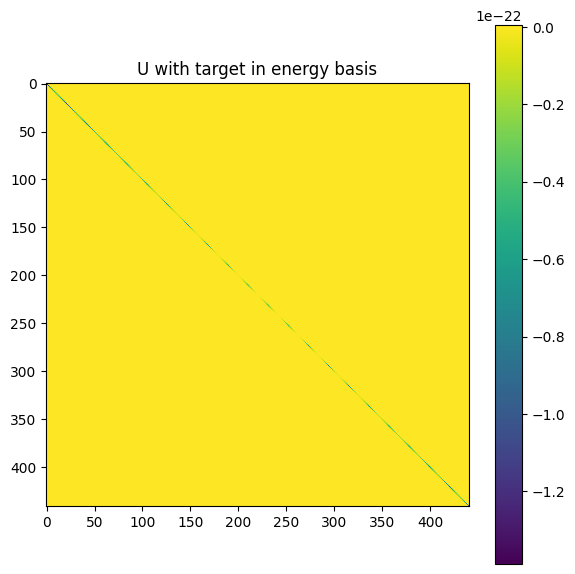

In [10]:
# Initialize transmon

# Circuit constant
ng = 0.5
Cc = 18e-15
Ej_p = 18.2e9
Ej_t = 11.8e9
Cp = 270e-15
Ct = 250e-15
ncut_p = 10
ncut_t = 10

# Creation of circuit object
system_11 = circuit_cap(Cc, [qubit(Ej_p, [Cp], ng, ncut_p), qubit(Ej_t, [Ct], ng, ncut_t)])

system_11.print_params()

# U_ebcb = system_2.get_U_circuit()[0]
U_ebeb = system_11.get_U_cb()

# U_ebeb = U_ebeb.toarray()
# U_ebcb = U_ebcb.toarray()

# U_ebeb = U_ebeb.astype(float)
# U_ebcb = U_ebcb.astype(float)

f = plt.figure(figsize=(15,7))

ax1 = f.add_subplot(121)
ax1.title.set_text('U with target in energy basis')
im1 = ax1.imshow(U_ebeb, cmap=plt.get_cmap(thememap))
f.colorbar(im1)

# ax2 = f.add_subplot(122)
# ax2.title.set_text('U with target in charge basis')
# im2 = ax2.imshow(U_ebcb, cmap=plt.get_cmap(thememap))
# f.colorbar(im2)

ax1.grid(False)
# ax2.grid(False)

plt.show()

Ejp:    18.200000000000003 GHz
Ecp:    0.2869663603653203 GHz
Cjp:    270.0 fF
Ejp/Ecp probe: 63.42206792751119
w_probe:    6.162432921919601 GHz
ng probe:    0.5
Ejt:    11.799999999999999 GHz
Ec:    0.309923669194546 GHz
Cjt:    250.0 fF
Ejt/Ect target: 38.073891002474156
w_target:    5.077795771645749 GHz
ng target:    0.5
detunning:    1.084637150273852 GHz
Cc:    18.0 fF


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:28<00:00,  3.45it/s]


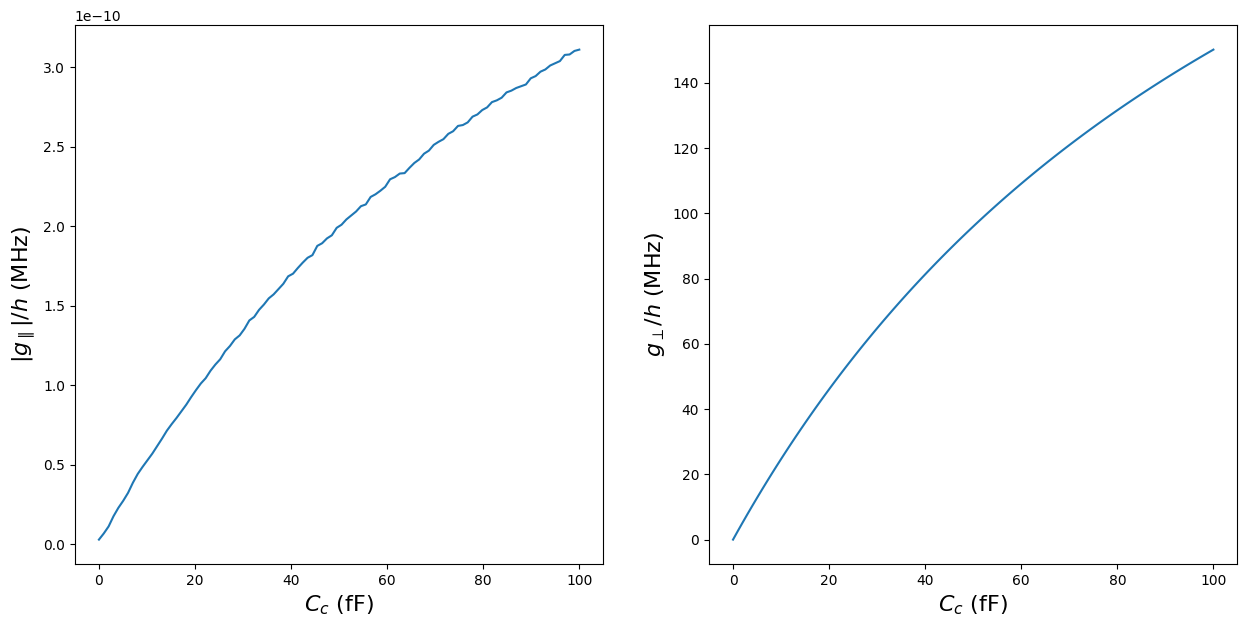

In [11]:
# Initialize transmon

# Circuit constant
ng = 0.5
Cc = 18e-15
Ej_p = 18.2e9
Ej_t = 11.8e9
Cp = 270e-15
Ct = 250e-15
ncut_p = 10
ncut_t = 10

# Creation of circuit object
system_12 = circuit_cap(Cc, [qubit(Ej_p, [Cp], 0.5, ncut_p), qubit(Ej_t, [Ct], ng, ncut_t)])

system_12.print_params()

Ccs = np.linspace(0, 10e-14, 100)

fig_data_gparr = []
fig_data_gperp = []

for Cc in tqdm(Ccs):
    system_12.Cc = Cc

    # Full Hamiltonina Approach
    g_parr = system_12.get_g_parr_cb(update=True)
    g_perp = system_12.get_g_perp_cb()
    fig_data_gparr.append(g_parr)
    fig_data_gperp.append(g_perp)

pparam = dict(xlabel='$C_c$ (fF)', ylabel='$| g_\parallel | / h$ (MHz)')

with plt.style.context([]):
    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(121)
    ax1.plot([val * 1e15 for val in Ccs], [np.abs(g_parr) * 1e-6 / h for g_parr in fig_data_gparr])
    ax1.set(**pparam)
    ax1.xaxis.label.set_size(16)
    ax1.yaxis.label.set_size(16)
    pparam = dict(xlabel='$C_c$ (fF)', ylabel='$g_\\perp / h$ (MHz)')
    ax2 = fig.add_subplot(122)
    ax2.plot([val * 1e15 for val in Ccs], [np.abs(g_parr) * 1e-6 / h for g_parr in fig_data_gperp])
    ax2.set(**pparam)
    ax2.xaxis.label.set_size(16)
    ax2.yaxis.label.set_size(16)

    plt.show()

##### Varying Ej


Ejp:    18.200000000000003 GHz
Ecp:    0.2869663603653203 GHz
Cjp:    270.0 fF
Ejp/Ecp probe: 63.42206792751119
w_probe:    6.162432921919601 GHz
ng probe:    0.5
Ejt:    11.799999999999999 GHz
Ec:    0.309923669194546 GHz
Cjt:    250.0 fF
Ejt/Ect target: 38.073891002474156
w_target:    5.077904256322749 GHz
ng target:    0
detunning:    1.084528665596852 GHz
Cc:    18.0 fF


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:29<00:00,  3.38it/s]


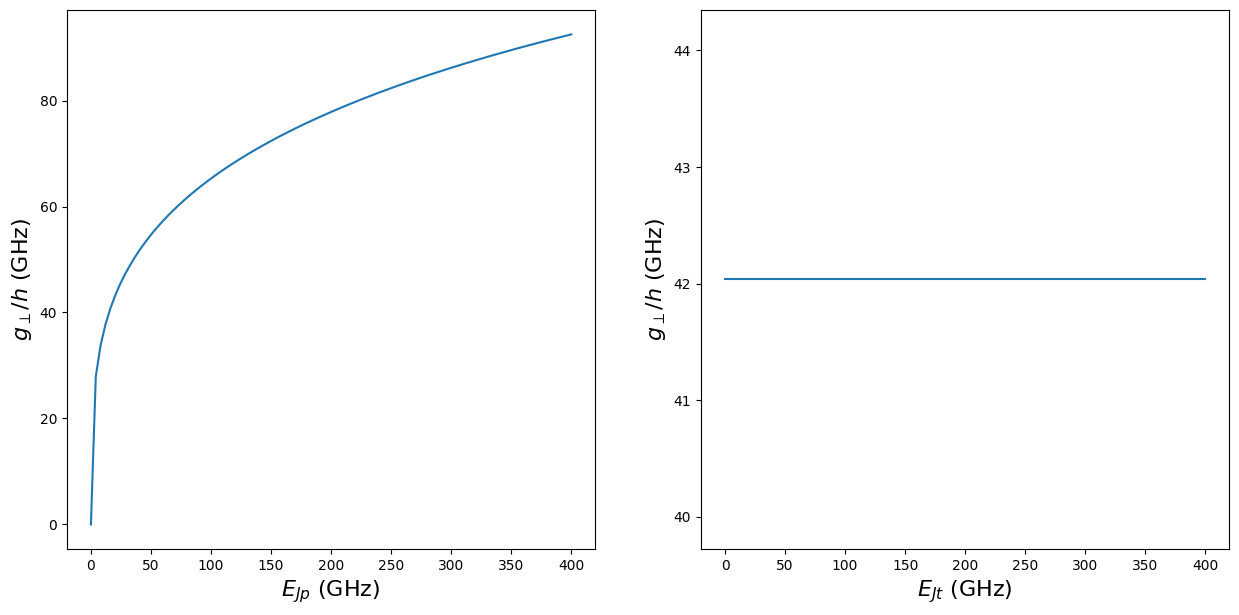

In [15]:
# Initialize transmon

# Circuit constant
ng = 0.5
Cc = 18e-15
Ej_p = 18.2e9
Ej_t = 11.8e9
Cp = 270e-15
Ct = 250e-15
ncut_p = 10
ncut_t = 10

# Creation of circuit object
system_4 = circuit_cap(Cc, [qubit(Ej_p, [Cp], ng, ncut_p), qubit(Ej_t, [Ct], 0, ncut_t)])

system_4.print_params()

Ejps = np.linspace(0, 400e9, 100)
fig_data_Ejp_g_parr = []
Ejts = np.linspace(0, 400e9, 100)
fig_data_Ejt_g_parr = []

for Ejp in tqdm(Ejps):
    system_4.probe.Ej = Ejp*h
    
    g_parr = system_4.get_g_perp_cb(update=True)
    fig_data_Ejp_g_parr.append(g_parr)
    
system_4.probe.Ej = 18.2e9 * constants.h
for Ejt in tqdm(Ejts):
    system_4.target.Ej = Ejt*h

    g_parr = system_4.get_g_perp_cb(update=True)
    fig_data_Ejt_g_parr.append(g_parr)

with plt.style.context([]):
    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(121)
    pparam = dict(xlabel='$E_{Jp}$ (GHz)', ylabel='$g_\\perp / h$ (GHz)')
    ax1.plot([val * 1e-9 for val in Ejps], [np.abs(g_parr) * 1e-6 / h for g_parr in fig_data_Ejp_g_parr])
    ax1.set(**pparam)
    ax1.xaxis.label.set_size(16)
    ax1.yaxis.label.set_size(16)
    pparam = dict(xlabel='$E_{Jt}$ (GHz)', ylabel='$g_\\perp / h$ (GHz)')
    ax2 = fig.add_subplot(122)
    ax2.plot([val * 1e-9 for val in Ejts], [np.abs(g_parr) * 1e-6 / h for g_parr in fig_data_Ejt_g_parr])
    ax2.set(**pparam)
    ax2.xaxis.label.set_size(16)
    ax2.yaxis.label.set_size(16)

    plt.show()

##### Varying Ct and Cp

Ejp:    18.200000000000003 GHz
Ecp:    0.2869663603653203 GHz
Cjp:    270.0 fF
Ejp/Ecp probe: 63.42206792751119
w_probe:    6.162432921919601 GHz
ng probe:    0.5
Ejt:    11.799999999999999 GHz
Ec:    0.309923669194546 GHz
Cjt:    250.0 fF
Ejt/Ect target: 38.073891002474156
w_target:    5.077904256322749 GHz
ng target:    0
detunning:    1.084528665596852 GHz
Cc:    18.0 fF


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:29<00:00,  3.37it/s]


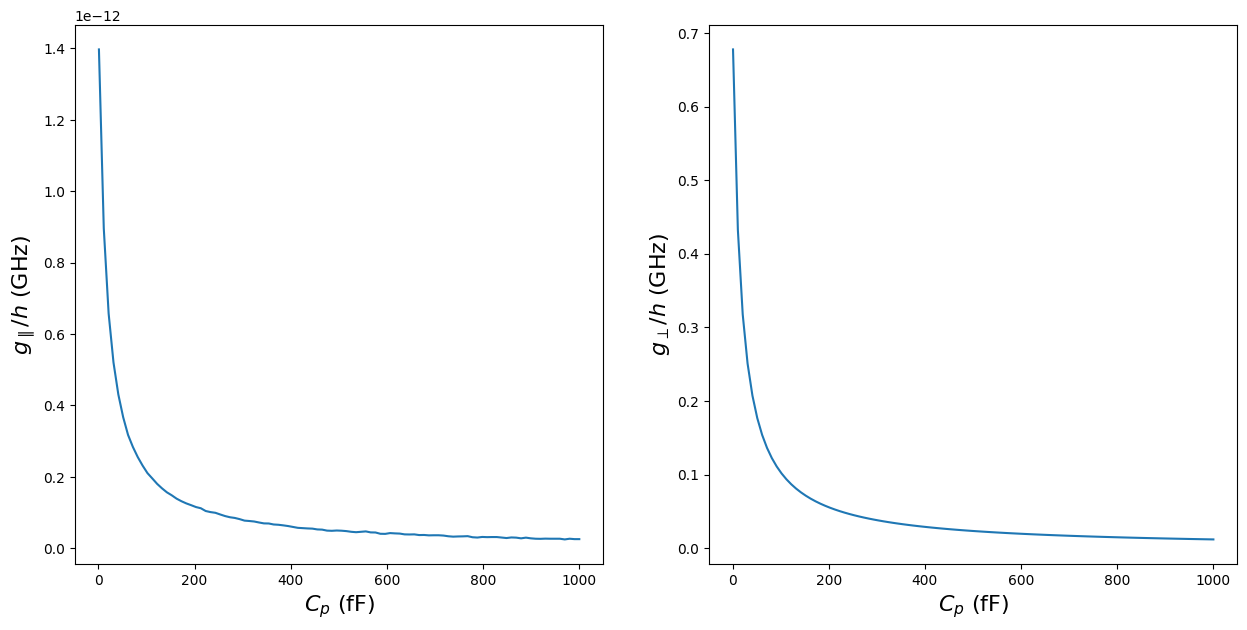

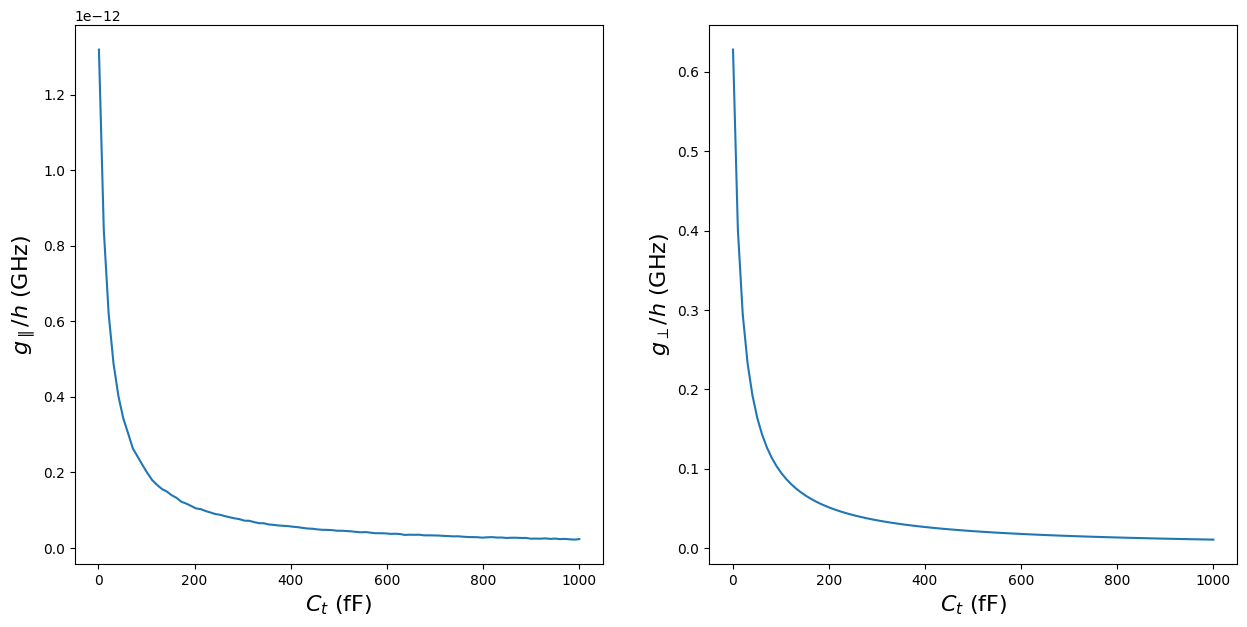

In [17]:
# Initialize transmon

# Circuit constant
ng = 0.5
Cc = 18e-15
Ej_p = 18.2e9
Ej_t = 11.8e9
Cp = 270e-15
Ct = 250e-15
ncut_p = 10
ncut_t = 10

# Creation of circuit object
system_5 = circuit_cap(Cc, [qubit(Ej_p, [Cp], ng, ncut_p), qubit(Ej_t, [Ct], 0, ncut_t)])

system_5.print_params()

Cps = np.linspace(1e-15, 10e-13, 100)
fig_pt_detuning_Cp_g_parr = []
fig_pt_detuning_Cp_g_perp = []
fig_pt_detuning_Ct = np.linspace(1e-15, 10e-13, 100)
fig_pt_detuning_Ct_g_parr = []
fig_pt_detuning_Ct_g_perp = []

for Cp in tqdm(Cps):
    system_5.probe.C = Cp

    g_parr = system_5.get_g_parr_cb(update=True)
    fig_pt_detuning_Cp_g_parr.append(g_parr)
    
    g_perp = system_5.get_g_perp_cb()
    fig_pt_detuning_Cp_g_perp.append(g_perp)

system_5.probe.C = 270e-15

for Ct in tqdm(fig_pt_detuning_Ct):
    system_5.target.C = Ct

    g_parr = system_5.get_g_parr_cb(update=True)
    fig_pt_detuning_Ct_g_parr.append(g_parr)
    
    g_perp = system_5.get_g_perp_cb()
    fig_pt_detuning_Ct_g_perp.append(g_perp)

with plt.style.context([]):
    fig = plt.figure(figsize=(15,7))
    pparam = dict(xlabel='$C_{p}$ (fF)', ylabel='$g_{\parallel} / h$ (GHz)')
    ax1 = fig.add_subplot(121)
    ax1.plot([val * 1e15 for val in Cps], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_pt_detuning_Cp_g_parr])
    ax1.set(**pparam)
    ax1.xaxis.label.set_size(16)
    ax1.yaxis.label.set_size(16)

    pparam = dict(xlabel='$C_{p}$ (fF)', ylabel='$g_{\perp} / h$ (GHz)')
    ax2 = fig.add_subplot(122)
    ax2.plot([val * 1e15 for val in Cps], [np.abs(g_perp) * 1e-9 / h for g_perp in fig_pt_detuning_Cp_g_perp])
    ax2.set(**pparam)
    ax2.xaxis.label.set_size(16)
    ax2.yaxis.label.set_size(16)
    plt.show()

pparam = dict(xlabel='$C_t$ (fF)', ylabel='$g_\\parallel / h$ (GHz)')

with plt.style.context([]):
    fig = plt.figure(figsize=(15,7))
    pparam = dict(xlabel='$C_t$ (fF)', ylabel='$g_{\parallel} / h$ (GHz)')
    ax1 = fig.add_subplot(121)
    ax1.plot([val * 1e15 for val in fig_pt_detuning_Ct], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_pt_detuning_Ct_g_parr])
    ax1.set(**pparam)
    ax1.xaxis.label.set_size(16)
    ax1.yaxis.label.set_size(16)

    pparam = dict(xlabel='$C_t$ (fF)', ylabel='$g_{\perp} / h$ (GHz)')
    ax2 = fig.add_subplot(122)
    ax2.plot([val * 1e15 for val in fig_pt_detuning_Ct], [np.abs(g_perp) * 1e-9 / h for g_perp in fig_pt_detuning_Ct_g_perp])
    ax2.set(**pparam)
    ax2.xaxis.label.set_size(16)
    ax2.yaxis.label.set_size(16)
    plt.show()

#### Varying detunning

Ejp:    18.200000000000003 GHz
Ecp:    0.2869663603653203 GHz
Cjp:    270.0 fF
Ejp/Ecp probe: 63.42206792751119
w_probe:    6.162432921919601 GHz
ng probe:    0.5
Ejt:    11.799999999999999 GHz
Ec:    0.309923669194546 GHz
Cjt:    250.0 fF
Ejt/Ect target: 38.073891002474156
w_target:    5.077795771645749 GHz
ng target:    0.5
detunning:    1.084637150273852 GHz
Cc:    18.0 fF


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:30<00:00,  3.33it/s]


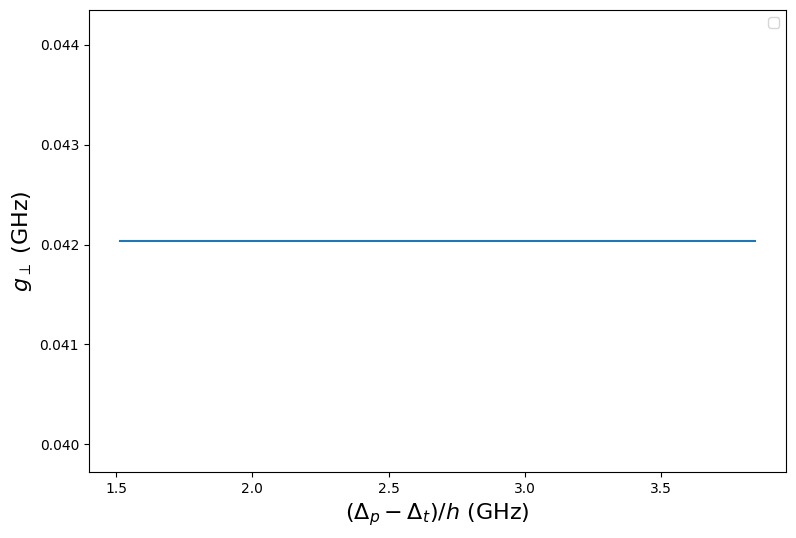

In [18]:
# Initialize transmon

# Circuit constant
ng = 0.5
Cc = 18e-15
Ej_p = 18.2e9
Ej_t = 11.8e9
Cp = 270e-15
Ct = 250e-15
ncut_p = 10
ncut_t = 10

#0 detunning
# Ej_t = 4e9
# Ct = 300e-15

ncut_p = 10
ncut_t = 10
# Creation of circuit object
system_9 = circuit_cap(Cc, [qubit(Ej_p, [Cp], ng, ncut_p), qubit(Ej_t, [Ct], ng, ncut_t)])

system_9.print_params()

# fig_pt_detuning_Ejt = np.linspace(8.5e9, 27e9, 20)
fig_pt_detuning_Ejt = np.linspace(3e9, 10e9, 100)
fig_pt_detuning_Ejt_g_parr = []
fig_pt_detuning_Ejt_delta_t = []
fig_pt_detuning_Ejt_delta_t_bare = []
fig_pt_detuning_Ejt_delta_p = []



for Ejt in tqdm(fig_pt_detuning_Ejt):
    system_9.target.Ej = Ejt * h

    # Full Hamiltonina Approach
    g_parr = system_9.get_g_perp_cb(update=True)
    fig_pt_detuning_Ejt_g_parr.append(g_parr)
    
    delta_t = system_9.get_omega_target()
    fig_pt_detuning_Ejt_delta_t.append(delta_t)
    
    delta_p = system_9.get_omega_probe()
    fig_pt_detuning_Ejt_delta_p.append(delta_p)

pparam = dict(xlabel='$(\\Delta_p - \\Delta_t) / h$ (GHz)', ylabel='$g_{\perp}$ (GHz)')

with plt.style.context([]):
    fig, ax = plt.subplots(figsize=(9,6))
    ax.plot([(np.abs(fig_pt_detuning_Ejt_delta_p[idx]) - np.abs(fig_pt_detuning_Ejt_delta_t[idx])) * 1e-9 / h for idx in range(len(fig_pt_detuning_Ejt))], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_pt_detuning_Ejt_g_parr])
    ax.set(**pparam)
    plt.legend()
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)

    plt.show()   

Ejp:    9.000000000000002 GHz
Ecp:    0.12913486216439415 GHz
Cjp:    150.0 fF
Ejp/Ecp probe: 69.69458014012218
w_probe:    2.9138875699855924 GHz
ng probe:    0.5
Ejt:    9.999999999999998 GHz
Ec:    0.11394252543917131 GHz
Cjt:    170.0 fF
Ejt/Ect target: 87.76354536163534
w_target:    2.9004336265829926 GHz
ng target:    0.5
detunning:    0.013453943402599934 GHz
Cc:    20.0 fF


100%|██████████| 100/100 [00:27<00:00,  3.70it/s]


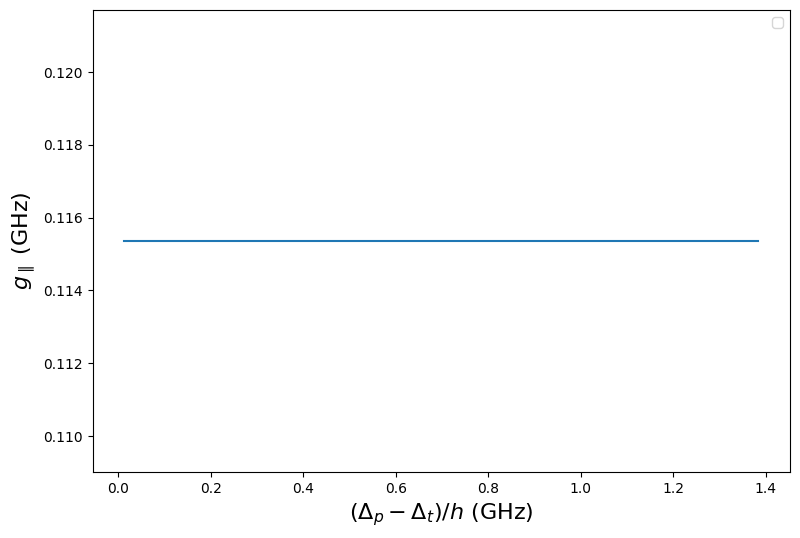

In [18]:
# Initialize transmon

# Circuit constant
ng = 0.5
Cc = 18e-15
Ej_p = 18.2e9
Ej_t = 11.8e9
Cp = 270e-15
Ct = 250e-15
ncut_p = 10
ncut_t = 10

#0 detunning
# Ej_t = 4e9
# Ct = 300e-15

ncut_p = 10
ncut_t = 10
# Creation of circuit object
system_9 = circuit_cap(Cc, [qubit(Ej_p, [Cp], ng, ncut_p), qubit(Ej_t, [Ct], ng, ncut_t)])

system_9.print_params()

# fig_pt_detuning_Ejt = np.linspace(8.5e9, 27e9, 20)
fig_pt_detuning_Ejt = np.linspace(3e9, 10e9, 100)
fig_pt_detuning_Ejt_g_parr = []
fig_pt_detuning_Ejt_delta_t = []
fig_pt_detuning_Ejt_delta_t_bare = []
fig_pt_detuning_Ejt_delta_p = []



for Ejt in tqdm(fig_pt_detuning_Ejt):
    system_9.target.Ej = Ejt * h

    # Full Hamiltonina Approach
    g_parr = system_9.get_g_perp_cb(update=True)
    fig_pt_detuning_Ejt_g_parr.append(g_parr)
    
    delta_t = system_9.get_omega_target()
    fig_pt_detuning_Ejt_delta_t.append(delta_t)
    
    delta_p = system_9.get_omega_probe()
    fig_pt_detuning_Ejt_delta_p.append(delta_p)

pparam = dict(xlabel='$(\\Delta_p - \\Delta_t) / h$ (GHz)', ylabel='$g_{\parallel}$ (GHz)')

with plt.style.context([]):
    fig, ax = plt.subplots(figsize=(9,6))
    ax.plot([(np.abs(fig_pt_detuning_Ejt_delta_p[idx]) - np.abs(fig_pt_detuning_Ejt_delta_t[idx])) * 1e-9 / h for idx in range(len(fig_pt_detuning_Ejt))], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_pt_detuning_Ejt_g_parr])
    ax.set(**pparam)
    plt.legend()
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)

    plt.show()  